## M1 - Original P1/P2 distribution via stratified=y

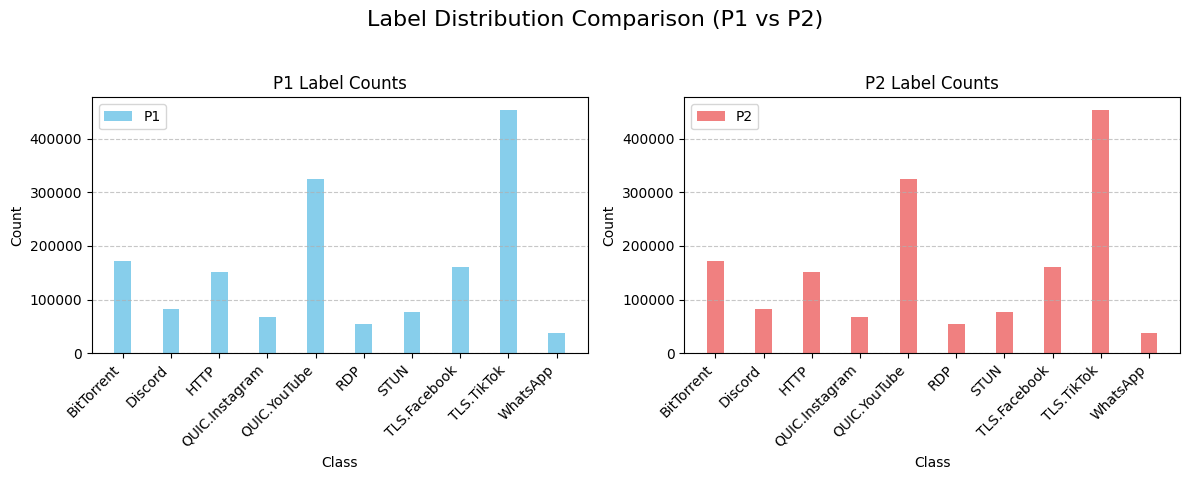

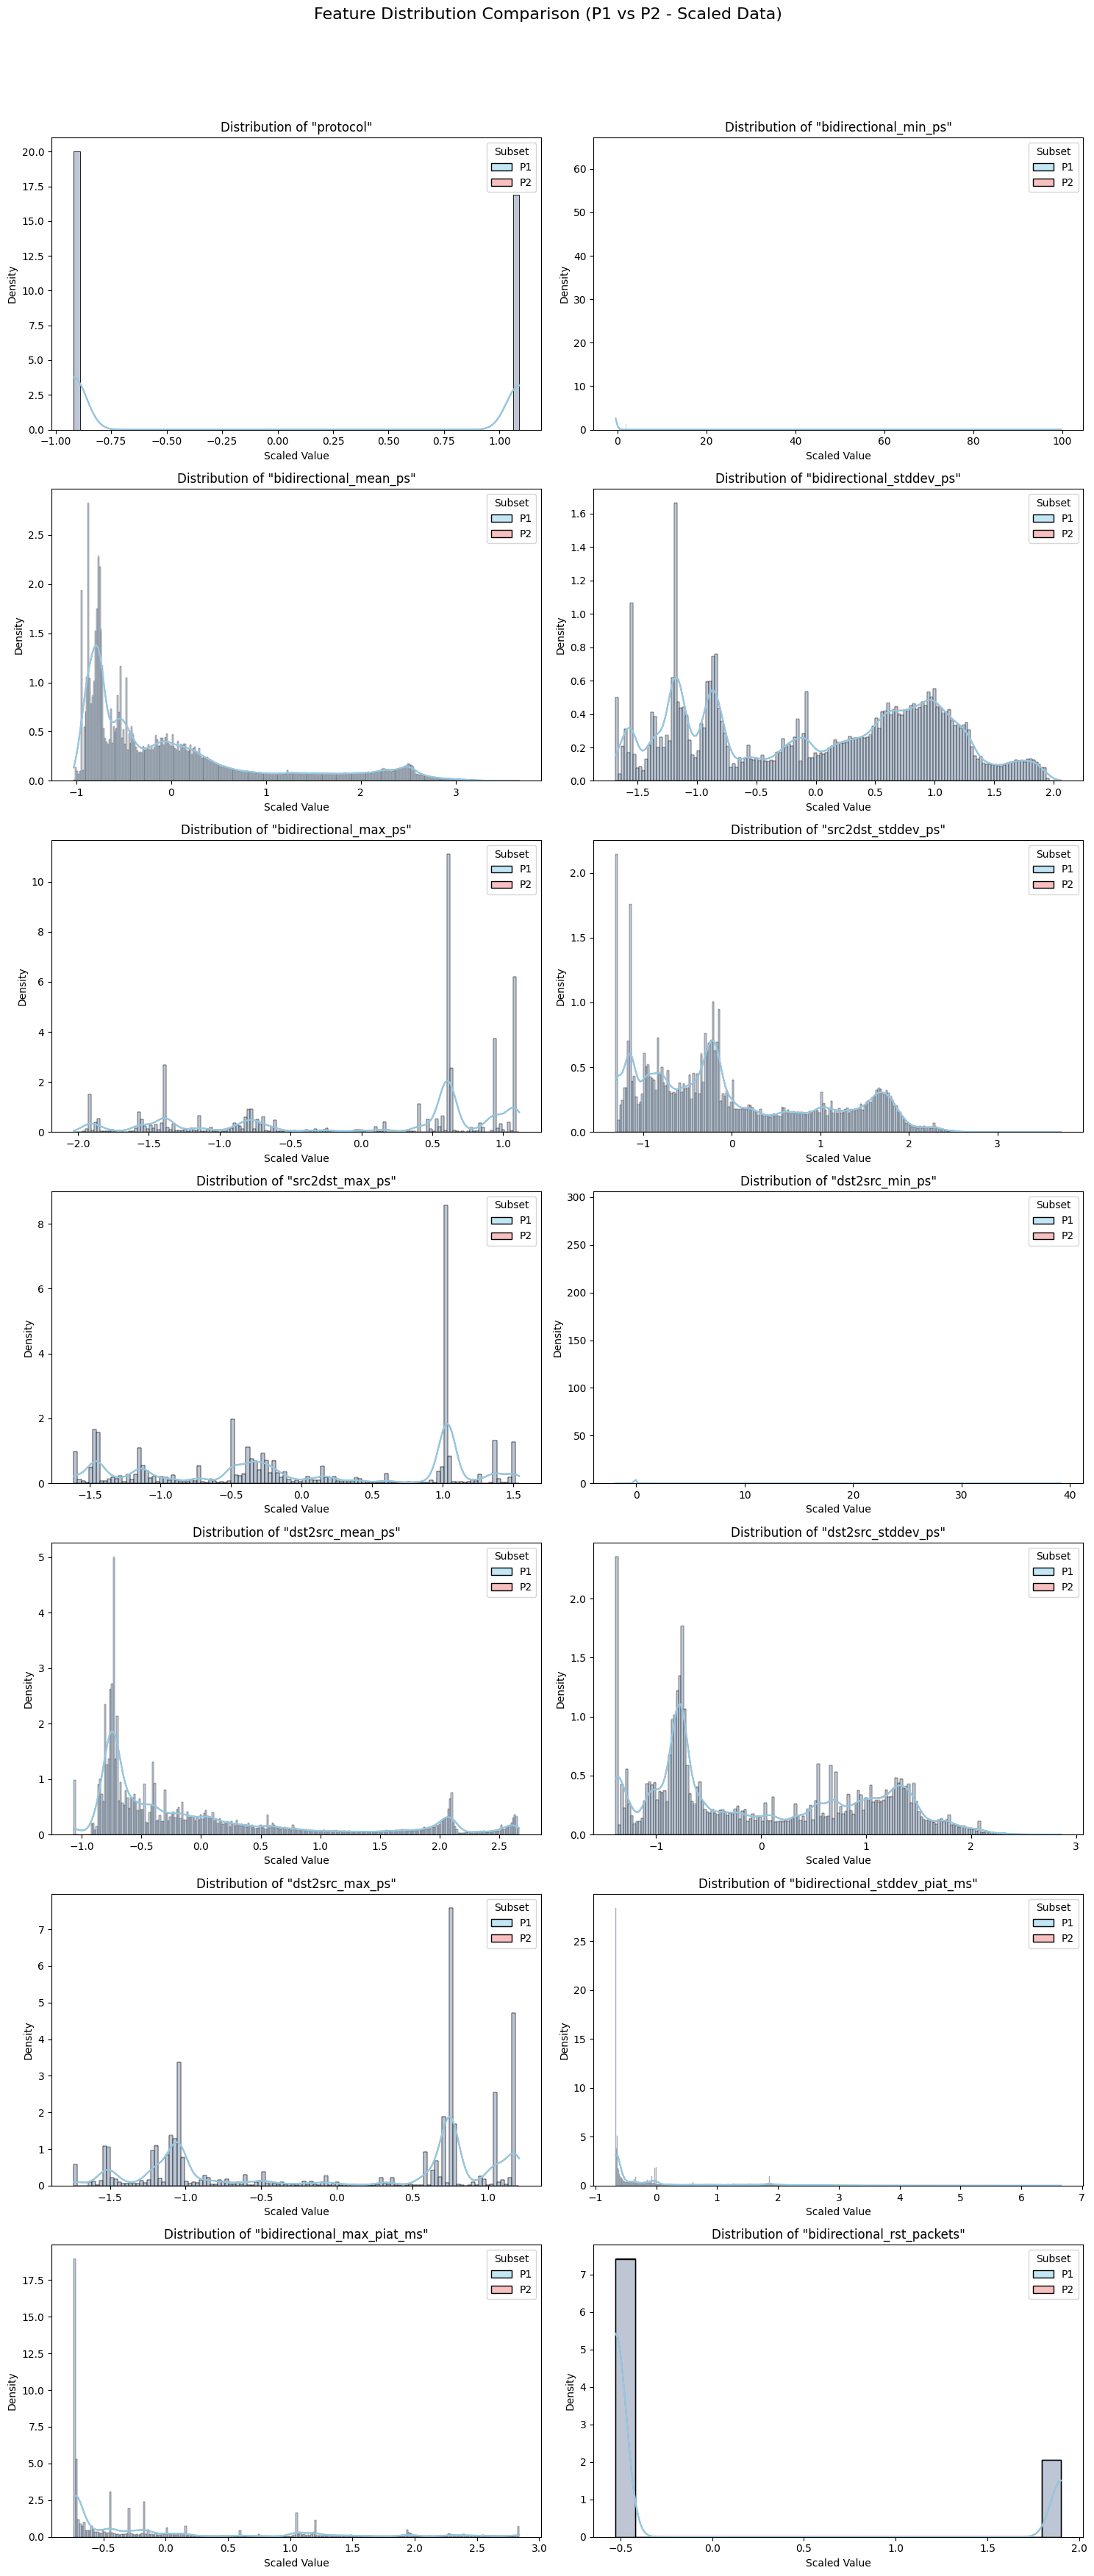

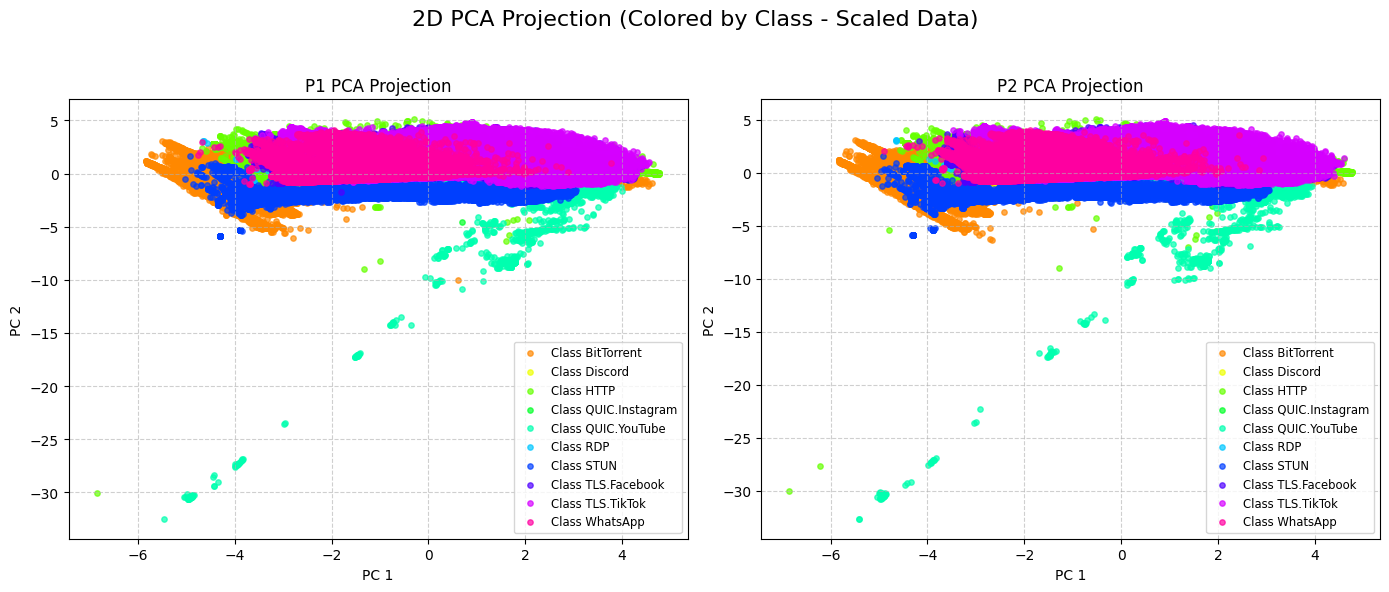

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler # Import StandardScaler
# import logging # Optional: for info messages
import warnings

# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# logger = logging.getLogger(__name__)

# Suppress the specific UserWarning about slow legends if desired
warnings.filterwarnings("ignore", category=UserWarning, module=".*pylabtools.*")

# --- Load data directly from parquet files ---
try:
    # logger.info("Loading data from datasets/p1.parquet and datasets/p2.parquet...")
    p1_df = pd.read_parquet('../datasets/p1-iid.parquet')
    p2_df = pd.read_parquet('../datasets/p2-iid.parquet')
    # logger.info("Data loaded successfully.")
except FileNotFoundError as e:
    # logger.error(f"Error loading parquet files: {e}. Make sure 'datasets/p1.parquet' and 'datasets/p2.parquet' exist.")
    raise # Re-raise the error to stop execution

# Column names (ensure these exactly match your parquet files)
feature_columns = [
    'protocol', 'bidirectional_min_ps', 'bidirectional_mean_ps',
    'bidirectional_stddev_ps', 'bidirectional_max_ps', 'src2dst_stddev_ps',
    'src2dst_max_ps', 'dst2src_min_ps', 'dst2src_mean_ps',
    'dst2src_stddev_ps', 'dst2src_max_ps', 'bidirectional_stddev_piat_ms',
    'bidirectional_max_piat_ms', 'bidirectional_rst_packets'
]
target_column = 'application_name'

# --- Data Extraction and Preprocessing ---
# logger.info("Extracting features and labels...")
# Extract features and ensure float type
X_p1_raw = p1_df[feature_columns].values.astype(np.float32)
y_p1 = p1_df[target_column].values

X_p2_raw = p2_df[feature_columns].values.astype(np.float32)
y_p2 = p2_df[target_column].values

# --- Fit LabelEncoder on combined labels ---
# logger.info("Encoding labels...")
label_encoder = LabelEncoder()
all_y = np.concatenate([y_p1, y_p2])
label_encoder.fit(all_y)
# Transform labels (optional for visualization, but often needed later)
# y_p1_encoded = label_encoder.transform(y_p1)
# y_p2_encoded = label_encoder.transform(y_p2)

# --- Scale Features ---
# logger.info("Scaling features using StandardScaler...")
scaler = StandardScaler()
# Combine X data for fitting the scaler consistently
X_combined_raw = np.vstack((X_p1_raw, X_p2_raw))
# Handle potential NaNs before scaling (replace with mean)
if np.any(np.isnan(X_combined_raw)):
    # logger.warning("NaN values found in features. Imputing with column means.")
    col_mean = np.nanmean(X_combined_raw, axis=0)
    inds = np.where(np.isnan(X_combined_raw))
    X_combined_raw[inds] = np.take(col_mean, inds[1])
    # Re-apply imputation separately to P1/P2 before transform if needed
    inds_p1 = np.where(np.isnan(X_p1_raw)); X_p1_raw[inds_p1] = np.take(col_mean, inds_p1[1])
    inds_p2 = np.where(np.isnan(X_p2_raw)); X_p2_raw[inds_p2] = np.take(col_mean, inds_p2[1])

# Fit scaler on the combined (and potentially imputed) data
scaler.fit(X_combined_raw)
# Transform P1 and P2 data separately
X_p1_scaled = scaler.transform(X_p1_raw)
X_p2_scaled = scaler.transform(X_p2_raw)
# logger.info("Feature scaling complete.")

# --- Visualization function ---
# Takes SCALED X data as input
def visualize_split_distributions(X_p1_scaled, y_p1, X_p2_scaled, y_p2, feature_columns, label_encoder, num_features_to_plot=14, seed=42):
    """
    Visualizes distributions for P1/P2 subsets using SCALED feature data.
    y_p1, y_p2 should be the original string labels.
    """
    # logger.info("Generating visualizations...")
    num_total_features = X_p1_scaled.shape[1]
    num_features_to_plot = min(num_features_to_plot, num_total_features)
    plot_feature_columns = feature_columns[:num_features_to_plot]

    # --- 1. Label Distribution Comparison ---
    plt.figure(figsize=(12, 5)) # Adjusted figsize slightly
    plt.suptitle("Label Distribution Comparison (P1 vs P2)", fontsize=16)

    unique_labels_p1, counts_p1 = np.unique(y_p1, return_counts=True)
    unique_labels_p2, counts_p2 = np.unique(y_p2, return_counts=True)

    # Use LabelEncoder's classes_ attribute for consistent ordering and all known labels
    all_labels = sorted(list(label_encoder.classes_)) # Get all labels known to encoder
    class_names = all_labels # Keep original string names for ticks

    # Use dictionaries for robust count lookup
    counts_dict_p1 = dict(zip(unique_labels_p1, counts_p1))
    counts_dict_p2 = dict(zip(unique_labels_p2, counts_p2))

    plot_counts_p1 = [counts_dict_p1.get(lbl, 0) for lbl in all_labels]
    plot_counts_p2 = [counts_dict_p2.get(lbl, 0) for lbl in all_labels]

    index = np.arange(len(all_labels)) # Numerical positions for bars
    bar_width = 0.35

    ax1 = plt.subplot(1, 2, 1)
    ax1.bar(index, plot_counts_p1, bar_width, label='P1', color='skyblue')
    ax1.set_title('P1 Label Counts')
    ax1.set_ylabel('Count')
    ax1.set_xlabel('Class') # Add x-axis label
    ax1.set_xticks(index)
    ax1.set_xticklabels(class_names, rotation=45, ha="right") # Rotate labels
    ax1.legend()
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    ax2 = plt.subplot(1, 2, 2)
    ax2.bar(index, plot_counts_p2, bar_width, label='P2', color='lightcoral')
    ax2.set_title('P2 Label Counts')
    ax2.set_ylabel('Count')
    ax2.set_xlabel('Class') # Add x-axis label
    ax2.set_xticks(index)
    ax2.set_xticklabels(class_names, rotation=45, ha="right") # Rotate labels
    ax2.legend()
    ax2.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout slightly
    plt.show()

    # --- 2. Feature Distribution Comparison (uses SCALED data) ---
    # logger.info(f"Plotting distributions for the first {num_features_to_plot} features (Scaled)...")
    rows = (num_features_to_plot + 1) // 2
    plt.figure(figsize=(15, 5 * rows))
    plt.suptitle("Feature Distribution Comparison (P1 vs P2 - Scaled Data)", fontsize=16, y=1.0)

    # Create DataFrame with SCALED data
    combined_df = pd.concat([
        pd.DataFrame(X_p1_scaled[:, :num_features_to_plot], columns=plot_feature_columns).assign(Subset='P1'),
        pd.DataFrame(X_p2_scaled[:, :num_features_to_plot], columns=plot_feature_columns).assign(Subset='P2')
    ])

    for i, feature_name in enumerate(plot_feature_columns):
        plt.subplot(rows, 2, i + 1)
        sns.histplot(data=combined_df, x=feature_name, hue='Subset', kde=True, palette={'P1':'skyblue', 'P2':'lightcoral'}, stat="density", common_norm=False)
        plt.title(f'Distribution of "{feature_name}"')
        plt.xlabel("Scaled Value") # Label axis correctly
        plt.ylabel("Density")     # Label axis correctly

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

    # --- 3. PCA Visualization (uses SCALED data) ---
    # logger.info("Plotting 2D PCA projection (Scaled)...")
    pca = PCA(n_components=2, random_state=seed)
    # Combine SCALED data for PCA fitting
    X_combined_scaled = np.vstack((X_p1_scaled, X_p2_scaled))

    # Check for NaNs/Infs *after* scaling (shouldn't happen if imputed before)
    if np.any(np.isnan(X_combined_scaled)) or np.any(np.isinf(X_combined_scaled)):
         # logger.error("NaN or Inf values found *after* scaling. Check scaler or input data. Skipping PCA.")
         return

    try:
        pca.fit(X_combined_scaled)
        X_p1_pca = pca.transform(X_p1_scaled)
        X_p2_pca = pca.transform(X_p2_scaled)
    except ValueError as e:
        # logger.error(f"PCA failed: {e}. Skipping PCA plot.")
        return

    plt.figure(figsize=(14, 6))
    plt.suptitle("2D PCA Projection (Colored by Class - Scaled Data)", fontsize=16)

    # Use the sorted list of all labels from the encoder
    palette = sns.color_palette("hsv", len(all_labels))
    label_to_color = dict(zip(all_labels, palette))

    ax3 = plt.subplot(1, 2, 1)
    for lbl in all_labels:
        idx = y_p1 == lbl # Compare against original string labels
        if np.any(idx): # Only plot if label exists in subset
            ax3.scatter(X_p1_pca[idx, 0], X_p1_pca[idx, 1], label=f'Class {lbl}', alpha=0.7, s=15, color=label_to_color.get(lbl))
    ax3.set_title('P1 PCA Projection'); ax3.set_xlabel('PC 1'); ax3.set_ylabel('PC 2'); ax3.grid(True, linestyle='--', alpha=0.6)
    ax3.legend(fontsize='small', loc='best') # Adjust legend
    # ax3.legend(fontsize='small', loc='center left', bbox_to_anchor=(1, 0.5)) # Example: Place outside to the right

    ax4 = plt.subplot(1, 2, 2)
    for lbl in all_labels:
        idx = y_p2 == lbl # Compare against original string labels
        if np.any(idx): # Only plot if label exists in subset
            ax4.scatter(X_p2_pca[idx, 0], X_p2_pca[idx, 1], label=f'Class {lbl}', alpha=0.7, s=15, color=label_to_color.get(lbl))
    ax4.set_title('P2 PCA Projection'); ax4.set_xlabel('PC 1'); ax4.set_ylabel('PC 2'); ax4.grid(True, linestyle='--', alpha=0.6)
    ax4.legend(fontsize='small', loc='best') # Adjust legend
    # ax4.legend(fontsize='small', loc='center left', bbox_to_anchor=(1, 0.5)) # Example: Place outside to the right

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    # logger.info("Visualizations complete.")


# --- Run visualization directly ---
# Pass the SCALED feature data to the function
visualize_split_distributions(X_p1_scaled, y_p1, X_p2_scaled, y_p2, feature_columns, label_encoder)

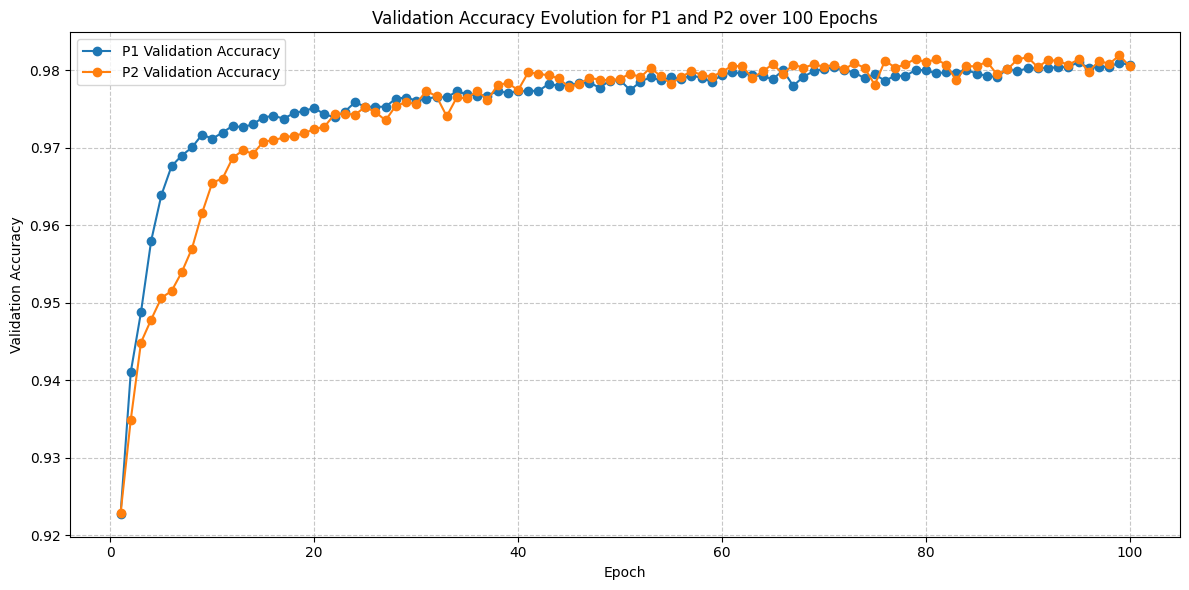

In [2]:
import matplotlib.pyplot as plt
import json

# Load data from the new JSON file for local baseline
local_baseline_file_path = "iid/local_baseline_s42_20250303_163933.json"
with open(local_baseline_file_path, 'r') as f:
    local_data = json.load(f)

# Extract validation accuracies for each epoch for P1 and P2
p1_val_accuracy = local_data['results']['models']['M1']['training']['val_accuracy']
p2_val_accuracy = local_data['results']['models']['M2']['training']['val_accuracy']
epochs = list(range(1, len(p1_val_accuracy) + 1))

# Plotting validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(epochs, p1_val_accuracy, label='P1 Validation Accuracy', marker='o')
plt.plot(epochs, p2_val_accuracy, label='P2 Validation Accuracy', marker='o')
plt.title('Validation Accuracy Evolution for P1 and P2 over 100 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

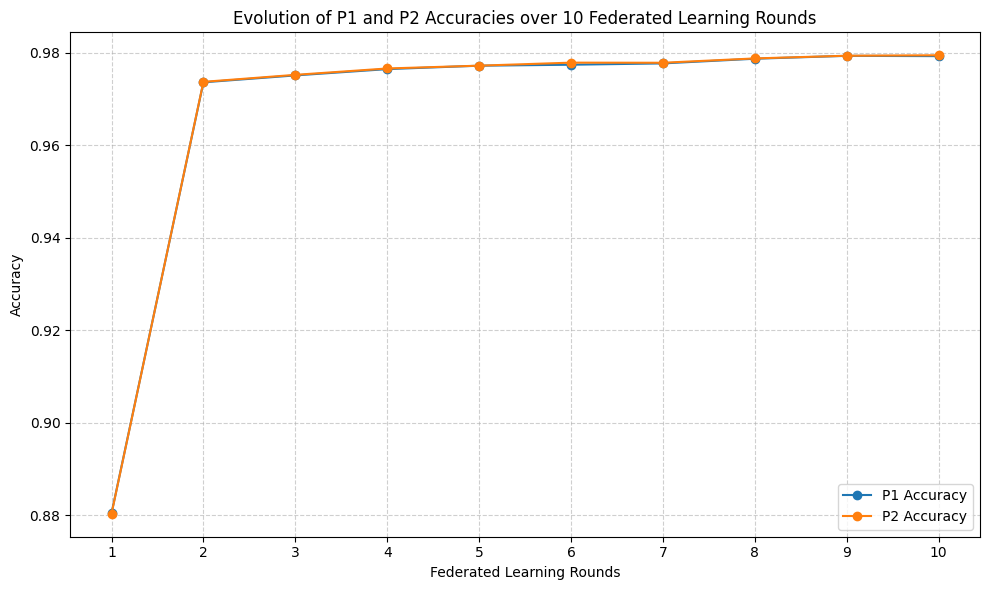

In [3]:
import matplotlib.pyplot as plt
import json

# Load data from the provided JSON file
file_path = "iid/federated_r10_e10_s42_20250303_163948.json"
with open(file_path, 'r') as f:
    data = json.load(f)

# Extract accuracies for each round for P1 and P2
rounds = data['results']['rounds']
p1_accuracies = [round_data['global_evaluation']['P1']['accuracy'] for round_data in rounds]
p2_accuracies = [round_data['global_evaluation']['P2']['accuracy'] for round_data in rounds]
round_numbers = list(range(1, len(rounds) + 1))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(round_numbers, p1_accuracies, marker='o', label='P1 Accuracy')
plt.plot(round_numbers, p2_accuracies, marker='o', label='P2 Accuracy')
plt.title('Evolution of P1 and P2 Accuracies over 10 Federated Learning Rounds')
plt.xlabel('Federated Learning Rounds')
plt.ylabel('Accuracy')
plt.xticks(round_numbers)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

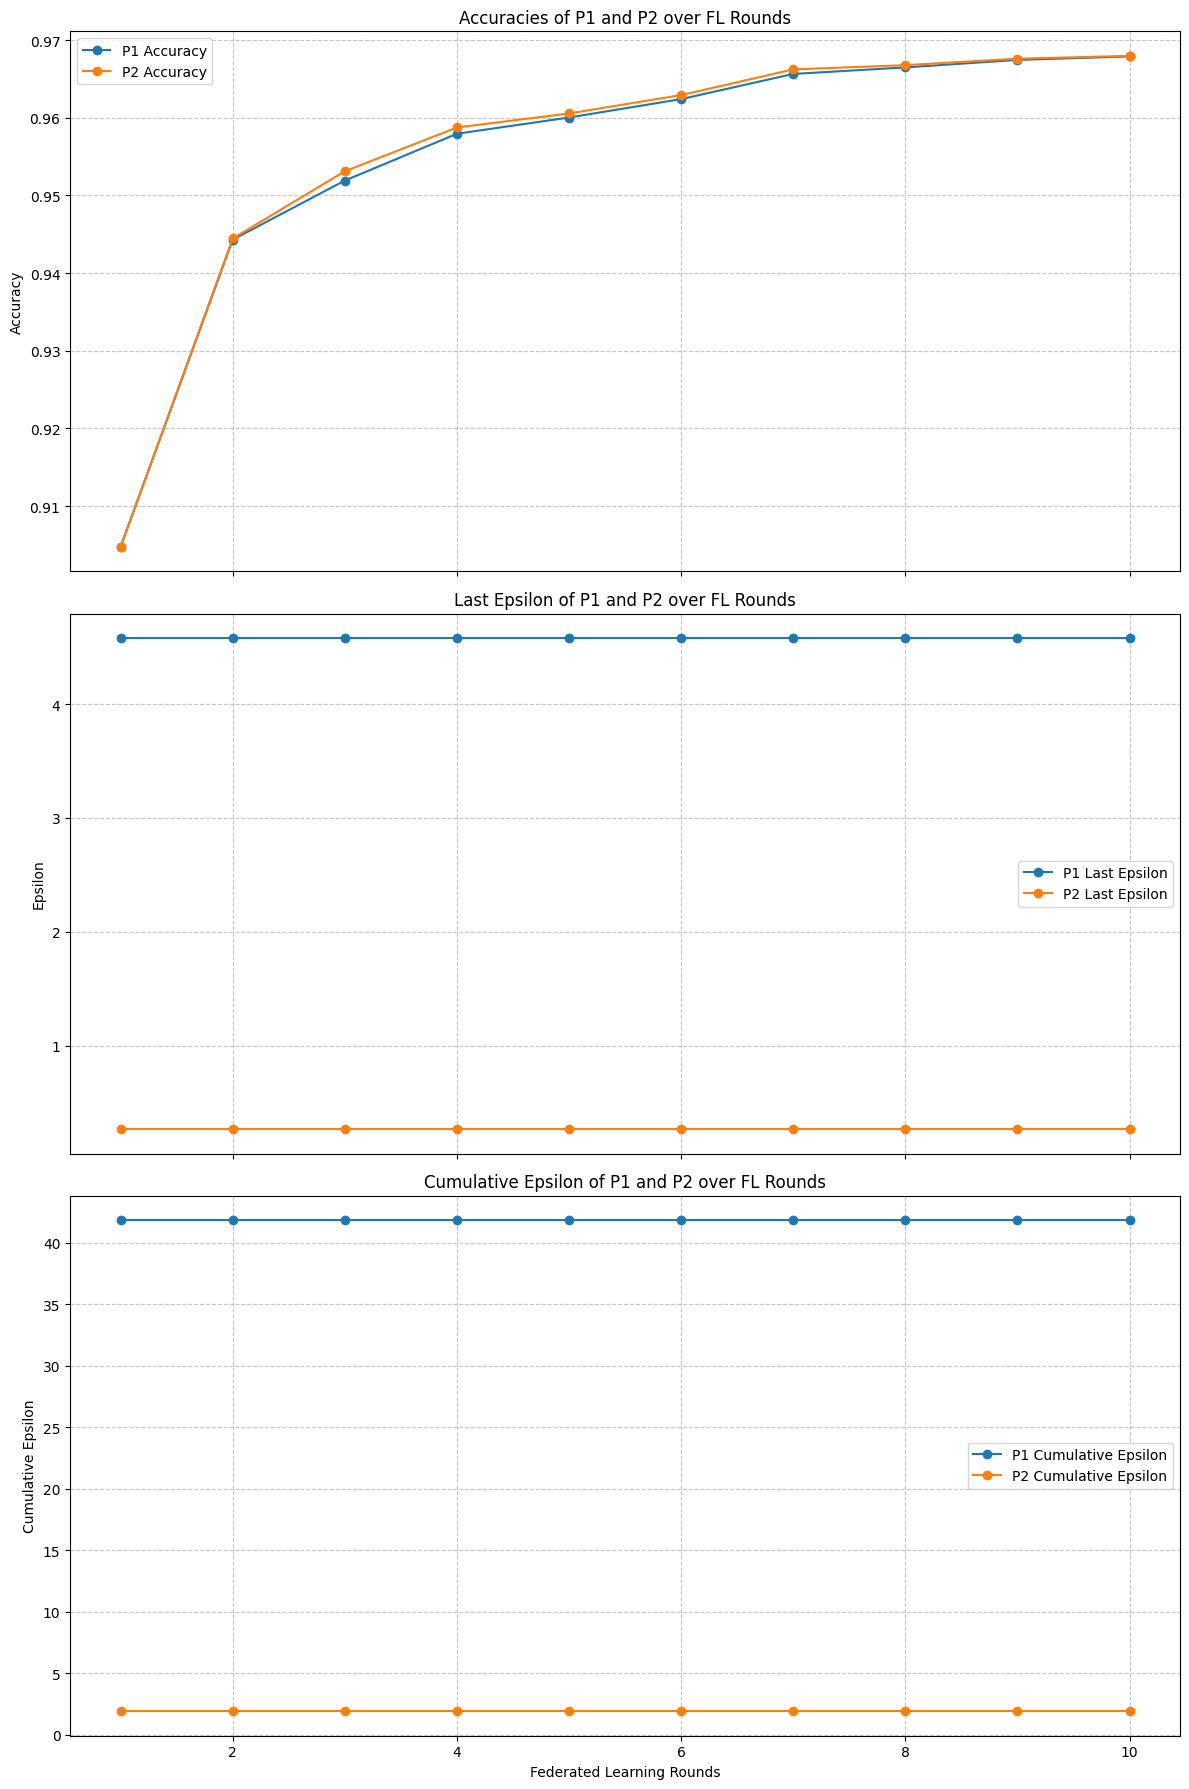

In [4]:
# Load the DP results dataset
dp_results_file_path = "iid/dp_experiments/results_p1_0.5_p2_1.0.json"
with open(dp_results_file_path, 'r') as f:
    dp_data = json.load(f)

# Extracting necessary data for visualization
rounds = dp_data['rounds']
round_numbers = list(range(1, len(rounds) + 1))

# Accuracies
p1_accuracies = [round_data['test_metrics']['p1']['accuracy'] for round_data in rounds]
p2_accuracies = [round_data['test_metrics']['p2']['accuracy'] for round_data in rounds]

# Last epsilon values
p1_last_epsilons = [round_data['epsilons']['p1'][-1] for round_data in rounds]
p2_last_epsilons = [round_data['epsilons']['p2'][-1] for round_data in rounds]

# Cumulative epsilons
p1_cum_epsilons = [round_data['cumulative_epsilons']['p1'][-1] for round_data in rounds]
p2_cum_epsilons = [round_data['cumulative_epsilons']['p2'][-1] for round_data in rounds]

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# Accuracy plot
axs[0].plot(round_numbers, p1_accuracies, marker='o', label='P1 Accuracy')
axs[0].plot(round_numbers, p2_accuracies, marker='o', label='P2 Accuracy')
axs[0].set_title('Accuracies of P1 and P2 over FL Rounds')
axs[0].set_ylabel('Accuracy')
axs[0].grid(True, linestyle='--', alpha=0.7)
axs[0].legend()

# Last epsilon plot
axs[1].plot(round_numbers, p1_last_epsilons, marker='o', label='P1 Last Epsilon')
axs[1].plot(round_numbers, p2_last_epsilons, marker='o', label='P2 Last Epsilon')
axs[1].set_title('Last Epsilon of P1 and P2 over FL Rounds')
axs[1].set_ylabel('Epsilon')
axs[1].grid(True, linestyle='--', alpha=0.7)
axs[1].legend()

# Cumulative epsilon plot
axs[2].plot(round_numbers, p1_cum_epsilons, marker='o', label='P1 Cumulative Epsilon')
axs[2].plot(round_numbers, p2_cum_epsilons, marker='o', label='P2 Cumulative Epsilon')
axs[2].set_title('Cumulative Epsilon of P1 and P2 over FL Rounds')
axs[2].set_xlabel('Federated Learning Rounds')
axs[2].set_ylabel('Cumulative Epsilon')
axs[2].grid(True, linestyle='--', alpha=0.7)
axs[2].legend()

plt.tight_layout()
plt.show()
